# Arabic POS Tagging Using Transformers <br>by **Mohammed Aly**
- [LinkedIn](https://www.linkedin.com/in/mohammed-aly-1854a020a/)  
- [GitHub](https://github.com/MohammedAly22/)

<html>
<img src="https://contenthub-static.grammarly.com/blog/wp-content/uploads/2023/10/5209-October-blog-header-Parts-of-Speech_Is-760x405.png" width="100%">
</html>

In natural language processing (NLP), **Part of Speech (POS)** refers to **the grammatical category** or syntactic function that a word serves in a sentence. It's a way of categorizing words based on their roles within the structure of a sentence. POS tagging involves assigning a specific label, such as **noun**, **verb**, **adjective**, **adverb**, etc., to each word in a sentence.

Here are some common parts of speech:

| Tag              | Arabic Tag | Description |
| :---------------- | ------: | :---- |
| Noun (N)        |   اسم   | Represents a person, place, thing, or idea. Examples: dog, city, happiness. |
| Verb (V)           |   فعل   | Describes an action or occurrence. Examples: run, eat, sleep. |
| Adjective (ADJ)    |  صفة   | Modifies or describes a noun. Examples: happy, tall, red. |
| Adverb (ADV) |  حال   | Modifies or describes a verb, adjective, or other adverb. Examples: quickly, very, well. |
| Pronoun (PRON) |  ضمير   | Replaces a noun. Examples: he, she, it. |
| Preposition (PREP) |  حرف جر   | Indicates relationships between words, often in terms of time or place. Examples: in, on, under. |
| Conjunction (CONJ) |  اقتران   | Connects words, phrases, or clauses. Examples: and, but, or. |
| Interjection (INTJ) |  تعجب   | Expresses strong emotion. Examples: wow, oh, ouch. |


**POS tagging** is an essential task in NLP because understanding the grammatical structure of a sentence helps machines comprehend the meaning and context of the text. It's particularly useful in applications like text analysis, information retrieval, and language translation.

# 1.0 Installing & Importing Required Packages

In [15]:
!pip install networkx

In [ ]:
!pip install transformers accelerate seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=1279b6cc21ab78c12d1bdab6a9077174d6aa513fb8a514244dba9a9a2c7c9844
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
!pip install datasets==2.13.1
!pip install fsspec==2023.9.2

  Obtaining dependency information for datasets==2.13.1 from https://files.pythonhosted.org/packages/12/17/95e48481a826f85c918e0610257de493164096e29fe16ec408c0b862e057/datasets-2.13.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 41.5 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.7
    Uninstalling dill-0.3.7:
      Successfully uninstalled dill-0.3.7
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.15
    Uninstalling multiprocess-0.70.15:
      Successfully uninstalled multiprocess-0.70.15
  Attempting uninstall: datasets
    Found existing installation: datase

In [ ]:
import datasets; datasets.__version__

'2.13.1'

In [ ]:
import ast
import requests
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from seqeval.metrics import f1_score, accuracy_score

import networkx as nx

import torch
from torch.nn.functional import cross_entropy

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import (AutoTokenizer, XLMRobertaForTokenClassification,
                          Trainer, TrainingArguments, AutoConfig,
                          DataCollatorForTokenClassification)

# 2.0 Loading & Exploring the Dataset
The [Arabic-PADT UD](https://github.com/UniversalDependencies/UD_Arabic-PADT) treebank is based on the Prague Arabic Dependency Treebank (PADT), created at the Charles University in Prague.

The treebank consists of 7,664 sentences (282,384 tokens) and its domain is mainly newswire. The annotation is licensed under the terms of CC BY-NC-SA 3.0 and its original (non-UD) version can be downloaded from http://hdl.handle.net/11858/00-097C-0000-0001-4872-3.

The morphological and syntactic annotation of the Arabic UD treebank is created through conversion of PADT data. The conversion procedure has been designed by Dan Zeman. The main coordinator of the original PADT project was Otakar Smrž.

Here is the first sample from the `ar_padt-ud-test.conllu` file:
```
# newdoc id = assabah.20041005.0017<br>
# newpar id = assabah.20041005.0017:p1<br>
# sent_id = assabah.20041005.0017:p1u1<br>
# text = <br>سوريا: تعديل وزاري واسع يشمل 8 حقائب
# orig_file_sentence ASB_ARB_20041005.0017#1<br>
1	سوريا	سُورِيَا	X	X---------	Foreign=Yes	0	root	0:root	SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=sUr|Translit=sūriyā|LTranslit=sūriyā<br>
2	:	:	PUNCT	G---------	_	1	punct	1:punct	Vform=:|Translit=:<br>
3	تعديل	تَعدِيل	NOUN	N------S1I	Case=Nom|Definite=Ind|Number=Sing	6	nsubj	6:nsubj<br>	Vform=تَعدِيلٌ|Gloss=adjustment,change,modification,amendment|Root=_d_l|Translit=taʿdīlun|LTranslit=tadīl<br>
4	وزاري	وِزَارِيّ	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod<br>	Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Root=w_z_r|Translit=wizārīyun|LTranslit=wizārīy<br>
5	واسع	وَاسِع	ADJ	A-----MS1I	Case=Nom|Definite=Ind|Gender=Masc|Number=Sing	3	amod	3:amod<br>	Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=w_s_|Translit=wāsiʿun|LTranslit=wāsi<br>
6	يشمل	شَمِل	VERB	VIIA-3MS--	Aspect=Imp|Gender=Masc|Mood=Ind|Number=Sing|Person=3|VerbForm=Fin|Voice=Act	1	parataxis	1:parataxis<br>	Vform=يَشمَلُ|Gloss=comprise,include,contain|Root=^s_m_l|Translit=yašmalu|LTranslit=šamil<br>
7	8	8	NUM	Q---------	NumForm=Digit	6	obj	6:obj	Vform=٨|Translit=8<br>
8	حقائب	حَقِيبَة	NOUN	N------P2I	Case=Gen|Definite=Ind|Number=Plur	7	nmod	7:nmod:gen<br>	Vform=حَقَائِبَ|Gloss=briefcase,suitcase,portfolio,luggage|Root=.h_q_b|Translit=ḥaqāʾiba|LTranslit=ḥaqībat<br>
```

In [ ]:
# Define the links of the dataset files
dataset_splits = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-train.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-test.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_Arabic-PADT/master/ar_padt-ud-dev.conllu",
}

# These are the standard column names for these `conllu` files
columns = ["ID", "FORM", "LEMMA", "UPOS", "XPOS", "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]


def get_dataframe_of_split(split):
    """
    Download and convert the `split` file to a pandas `DataFrame`
    
    Parameters
    ----------
    - split : str
        A string represents the name of a particular dataset 
        `split` ("train", "test", "dev").
    
    Returns
    -------
    - df : pd.DataFrame
        A pandas dataframe of the particular `split`.
    """
    
    # Download the datafile
    response = requests.get(dataset_splits[split])
    conllu_data = response.text
    lines = conllu_data.split('\n')
    data = []

    # Add a new column to the above columns `SENTENCE_ID` which can
    # tell us which words related to same sentence
    sentence_id = 0
    for line in lines:
        if line.startswith("# sent_id"):
            sentence_id += 1
        elif line.startswith("#") or line.strip() == "":
            continue
        else:
            values = line.split('\t')
            values.append(sentence_id)
            data.append(values)

    df = pd.DataFrame(data, columns=columns + ["SENTENCE_ID"])

    return df

## 2.1 Download the Dataset Files

In [ ]:
# Download all the `dataset_splits`
train_df = get_dataframe_of_split("train")
test_df = get_dataframe_of_split("test")
dev_df = get_dataframe_of_split("dev")

## 2.2 A First Look at the Dataset Splits

In [ ]:
train_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,برلين,بَرلِين,X,X---------,Foreign=Yes,2,nsubj,2:nsubj,Vform=بَرلِين|Gloss=Berlin|Root=barlIn|Transli...,1
1,2,ترفض,رَفَض,VERB,VIIA-3FS--,Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Per...,0,root,0:root,"Vform=تَرفُضُ|Gloss=reject,refuse|Root=r_f_.d|...",1
2,3,حصول,حُصُول,NOUN,N------S4R,Case=Acc|Definite=Cons|Number=Sing,2,obj,2:obj,"Vform=حُصُولَ|Gloss=acquisition,obtaining,occu...",1
3,4,شركة,شَرِكَة,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,3,nmod,3:nmod:gen,"Vform=شَرِكَةٍ|Gloss=company,corporation|Root=...",1
4,5,اميركية,أَمِيرِكِيّ,ADJ,A-----FS2I,Case=Gen|Definite=Ind|Gender=Fem|Number=Sing,4,amod,4:amod,Vform=أَمِيرِكِيَّةٍ|Gloss=American|Root='amIr...,1


In [ ]:
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,سوريا,سُورِيَا,X,X---------,Foreign=Yes,0,root,0:root,SpaceAfter=No|Vform=سُورِيَا|Gloss=Syria|Root=...,1
1,2,:,:,PUNCT,G---------,_,1,punct,1:punct,Vform=:|Translit=:,1
2,3,تعديل,تَعدِيل,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=تَعدِيلٌ|Gloss=adjustment,change,modific...",1
3,4,وزاري,وِزَارِيّ,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وِزَارِيٌّ|Gloss=ministry,ministerial|Ro...",1
4,5,واسع,وَاسِع,ADJ,A-----MS1I,Case=Nom|Definite=Ind|Gender=Masc|Number=Sing,3,amod,3:amod,"Vform=وَاسِعٌ|Gloss=wide,extensive,broad|Root=...",1


In [ ]:
dev_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,SENTENCE_ID
0,1,ميراث,مِيرَاث,NOUN,N------S1I,Case=Nom|Definite=Ind|Number=Sing,6,nsubj,6:nsubj,"Vform=مِيرَاثٌ|Gloss=inheritance,heritage|Root...",1
1,2,ب,بِ,ADP,P---------,AdpType=Prep,3,case,3:case,"SpaceAfter=No|Vform=بِ|Gloss=by,with|Root=bi|T...",1
2,3,300,300,NUM,Q---------,NumForm=Digit,1,nummod,1:nummod,Vform=٣٠٠|Translit=300,1
3,4,الف,أَلف,NUM,QM-----S2R,Case=Gen|Definite=Cons|Number=Sing|NumForm=Word,3,nummod,3:nummod,Vform=أَلفِ|Gloss=thousand|Root='_l_f|Translit...,1
4,5,دولار,دُولَار,NOUN,N------S2I,Case=Gen|Definite=Ind|Number=Sing,4,nmod,4:nmod:gen,Vform=دُولَارٍ|Gloss=dollar|Root=dUlAr|Transli...,1


As we can see, the train dataset consists of **254400** row and **11** columns. Each row corresponds to one word.

| Column | Status |
| ------ | ------ |
| ID | Sentence-level units in PADT often correspond to entire paragraphs and they were obtained automatically. Low-level tokenization (whitespace and punctuation) was done automatically and then hand-corrected. Splitting of fused tokens into syntactic words in Arabic is part of morphological analysis. [ElixirFM](http://elixir-fm.sf.net/) was used to provide context-independent options, then these results were disambiguated manually. |
| FORM | The unvocalized surface form is used. Fully vocalized counterpart can be found in the MISC column as Vform attribute. |
| LEMMA | Plausible analyses provided by ElixirFM, manual disambiguation. Lemmas are vocalized. Part of the selection of lemmas was also word sense disambiguation of the lexemes, providing English equivalents (see the Gloss attribute of the MISC column). |
| UPOSTAG | Converted automatically from XPOSTAG (via [Interset](http://ufal.mff.cuni.cz/interset)); human checking of patterns revealed by automatic consistency tests. |
| XPOSTAG | Manual selection from possibilities provided by ElixirFM. |
| FEATS | Converted automatically from XPOSTAG (via Interset); human checking of patterns revealed by automatic consistency tests. |
| HEAD | Original PADT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPREL | Original PDT annotation is manual. Automatic conversion to UD; human checking of patterns revealed by automatic consistency tests. |
| DEPS | &mdash; (currently unused) |
| MISC | Information about token spacing taken from PADT annotation. Additional word attributes provided by morphological analysis (i.e. ElixirFM rules + manual disambiguation): Vform (fully vocalized Arabic form), Translit (Latin transliteration of word form), LTranslit (Latin transliteration of lemma), Root (word root), Gloss (English translation of lemma). |

# 3.0 Dataset Preparation for Tokenization

## 3.1 Feature Selection
All these columns are invaluable for our task, I select only the columns that i need to accomplish this task: [sentence_id, id, form, upos]. In addition to changing these columns names to be representative.

In [ ]:
column_mapper = {
    "SENTENCE_ID": "sentence_id",
    "ID": "id",
    "FORM": "word",
    "UPOS": "tag",
}

train_df = train_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
test_df = test_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)
dev_df = dev_df[["SENTENCE_ID", "ID", "FORM", "UPOS"]].rename(columns=column_mapper)

In [ ]:
train_df.head()

,sentence_id,id,word,tag
0,1,1,برلين,X
1,1,2,ترفض,VERB
2,1,3,حصول,NOUN
3,1,4,شركة,NOUN
4,1,5,اميركية,ADJ


## 3.2 Get the All Unique Labels from `tag` Column

In [ ]:
unique_labels = train_df["tag"].unique().tolist()
print(f"There are {len(unique_labels)} unique label:\n{unique_labels}")

There are 18 unique label:
['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ']


## 3.3 Convert the Dataset to be Sentence-Based not Word-Based
In this step, I made a simple grouping by `sentence_id` hence each row corresponding to a specific `sentence_id` becomes a single row in the new dataframe.

In [ ]:
grouped_train_df = train_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_test_df = test_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()
grouped_dev_df = dev_df.groupby(["sentence_id"])[["word", "tag"]].agg(list).reset_index()

In [ ]:
# Rename the columns to be representative
agg_column_mapper = {
    "word": "text",
    "tag": "tags"
}

grouped_train_df.rename(columns=agg_column_mapper, inplace=True)
grouped_test_df.rename(columns=agg_column_mapper, inplace=True)
grouped_dev_df.rename(columns=agg_column_mapper, inplace=True)

grouped_train_df.head()

,sentence_id,text,tags
0,1,"[برلين, ترفض, حصول, شركة, اميركية, على, رخصة, ...","[X, VERB, NOUN, NOUN, ADJ, ADP, NOUN, NOUN, NO..."
1,2,"[برلين, 15, -, 7, (, اف, ب, ), -, افادت, صحيفة...","[X, NUM, PUNCT, NUM, PUNCT, X, X, PUNCT, PUNCT..."
2,3,"[وفي, و, في, نيسان, /, ابريل, الماضي, ،, تخلت,...","[_, CCONJ, ADP, NOUN, PUNCT, NOUN, ADJ, PUNCT,..."
3,4,"[وكانت, و, كانت, خسائر, المجموعة, الاسبانية, ا...","[_, CCONJ, VERB, NOUN, NOUN, ADJ, ADJ, VERB, A..."
4,5,"[واشارت, و, أشارت, صحيفة, الاحد, الى, ان, المس...","[_, CCONJ, VERB, NOUN, NOUN, ADP, SCONJ, NOUN,..."


As we can see from the above table, we ended up with a row for each sentence with thier corresponfing `text` and `tags` values

## 3.4 Saving the Final Dataframe as CSV Files
In this step, I saved the `grouped_x_df` to `csv` file for presistance and for loading them as a `Huggung Face Dataset` objects.

In [ ]:
grouped_train_df.to_csv("train_dataset.csv", index=0)
grouped_test_df.to_csv("test_dataset.csv", index=0)
grouped_dev_df.to_csv("dev_dataset.csv", index=0)

## 3.5 Loading the Saved CSV Files as a `Hugging Face DatasetDict`

In [ ]:
train_dataset = load_dataset("csv", data_files="/kaggle/working/train_dataset.csv")
test_dataset = load_dataset("csv", data_files="/kaggle/working/test_dataset.csv")
dev_dataset = load_dataset("csv", data_files="/kaggle/working/dev_dataset.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-edbb778da9002f22/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f05deff3e952704c/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a567aab1ee25f6b2/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

### 3.5.1 Convert the `DatasetDict` object to a `Dataset` object
Here I get the `Dataset` object from each `DatasetDict` object to construct a new `DatasetDict` object containing training, development, and testing sets.

In [ ]:
train_dataset = train_dataset["train"]
test_dataset = test_dataset["train"]
dev_dataset = dev_dataset["train"]

dataset = DatasetDict({"train": train_dataset, "test": test_dataset, "dev": dev_dataset})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags'],
        num_rows: 909
    })
})

## 3.6 Creating a `ClassLabel` Object for Out Unique POS Tags

In [ ]:
labels = ClassLabel(num_classes=len(unique_labels), names=unique_labels)
labels

ClassLabel(names=['X', 'VERB', 'NOUN', 'ADJ', 'ADP', 'PUNCT', 'NUM', '_', 'PRON', 'SCONJ', 'CCONJ', 'DET', 'PART', 'ADV', 'SYM', 'AUX', 'PROPN', 'INTJ'], id=None)

## 3.7 Feature Type Correction
In this step, I will correct the type of `text` and `tags` columns as they are currently `strings` and I need them to be of type `lists`.

In [ ]:
example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


In [ ]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'str'>
type of tags column: <class 'str'>


Here I used the `Abstract Syntax Tree (AST)` package for easily convert `strings` to `lists` using `literal_eval()` method

In [ ]:
def convert_columns_to_lists(example):
    """
    Convert `example` columns to a `list` rather than a `string`.
    
    Parameters
    ----------
    - example : dict
        A dict represents a particular example of the dataset.
        
    Returns
    -------
    - dict
        A new dictionary corresponding of the new dataset columns
        after conversion.
    """
    
    return {'text': ast.literal_eval(example['text']), 'tags': ast.literal_eval(example['tags'])}

dataset = dataset.map(convert_columns_to_lists)

Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [ ]:
example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']


In [ ]:
print(f"type of text column: {type(example['text'])}")
print(f"type of tags column: {type(example['tags'])}")

type of text column: <class 'list'>
type of tags column: <class 'list'>


## 3.8 Creating a new `pos_tags` Column using `labels` ClassLabel Object

In [ ]:
def tags2index(example):
    """
    Create a new column called `pos_tags` that contains the
    integer representation for each tag.
    
    Parameters
    ----------
    - example : dict
        A dict represents a particular example of the dataset.
        
    Returns
    -------
    - dict
        A new dictionary corresponding the integer value for 
        each tag in the `example`.
    """
    
    return {"pos_tags": labels.str2int(example["tags"])}

dataset = dataset.map(tags2index)

Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['sentence_id', 'text', 'tags', 'pos_tags'],
        num_rows: 909
    })
})

In [ ]:
example = dataset["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

sentence_id: 1
text: ['برلين', 'ترفض', 'حصول', 'شركة', 'اميركية', 'على', 'رخصة', 'تصنيع', 'دبابة', '"', 'ليوبارد', '"', 'الالمانية']
tags: ['X', 'VERB', 'NOUN', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'X', 'PUNCT', 'ADJ']
pos_tags: [0, 1, 2, 2, 3, 4, 2, 2, 2, 5, 0, 5, 3]


## 3.9 Showing the Number of Tags per Split

In [ ]:
split2freqs = defaultdict(Counter)

for split, ds in dataset.items():
    for row in ds["tags"]:
        for tag in row:
            split2freqs[split][tag] += 1

pd.DataFrame.from_dict(split2freqs, orient="index").T

,train,test,dev
X,13747.0,1380.0,2041.0
VERB,16789.0,2189.0,2318.0
NOUN,74546.0,9547.0,9612.0
ADJ,23498.0,2937.0,2916.0
ADP,33617.0,4528.0,4410.0
PUNCT,17511.0,2052.0,2882.0
NUM,6010.0,779.0,969.0
_,30519.0,3868.0,4022.0
PRON,8533.0,1133.0,1211.0
SCONJ,4368.0,534.0,555.0


# 4.0 Dataset Tokenization

## 4.1 Comparing between `BERT` and `XLM-R` Tokenizers

In [ ]:
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
text = "رفضت برلين ان ترفع الحصار من على ايطاليا"

bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

print(f"BERT tokens: \n{bert_tokens}\n")
print(f"XLMR tokens: \n{xlmr_tokens}\n")

BERT tokens: 
['[CLS]', 'ر', '##ف', '##ض', '##ت', 'ب', '##ر', '##ل', '##ي', '##ن', 'ا', '##ن', 'ت', '##ر', '##ف', '##ع', 'ا', '##ل', '##ح', '##ص', '##ا', '##ر', 'م', '##ن', 'ع', '##ل', '##ى', 'ا', '##ي', '##ط', '##ا', '##ل', '##ي', '##ا', '[SEP]']

XLMR tokens: 
['<s>', '▁رفض', 'ت', '▁بر', 'لين', '▁ان', '▁ت', 'رفع', '▁الح', 'صار', '▁من', '▁على', '▁اي', 'طال', 'يا', '</s>']



As we can see from the above generated tokens, XLM-R tokens are **superior** to BERT tokens and this due that XLM-R is trained on a huge **multillingual corpus** of around **100** languages and Arabic is one of them, so we cann that `xlmr_tokenizer` can deal with the Arabic text much better than `bert_tokenizer`

## 4.2 Loading and Configuring `XLMRobertaForTokenClassification` Model

In [ ]:
index2tag = {idx: tag for idx, tag in enumerate(labels.names)}
tag2index = {tag: idx for idx, tag in enumerate(labels.names)}

In [ ]:
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=labels.num_classes,
                                         id2label=index2tag,
                                         label2id=tag2index)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,
                                                               config=xlmr_config).to(device))

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4.3 A Closer Look at the Tokenization Process

In [ ]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Input IDs,0,98747,368,1359,41882,716,746,68581,12011,20573,230,556,5669,76522,2796,2


As we can see our `xlmr_tokenizer` is working by **SentencePiece Tokenizer**. In addiiton, we can notice that word `رفضت` is splitted into `▁رفض` and `ت` and this means that they should be merged together when returning them back to the original text.

## 4.4 Testing Model Before Fine-Tuning

In [ ]:
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 16
Shape of outputs: torch.Size([1, 16, 18])


Obviousliy, the output shape is of size **[batch_size, sequence_length, number_of_classes]**

In [ ]:
preds = [labels.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Tokens,<s>,▁رفض,ت,▁بر,لين,▁ان,▁ت,رفع,▁الح,صار,▁من,▁على,▁اي,طال,يا,</s>
Tags,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX,AUX


As we can see, we get a random tags of `AUX` because the model does not know how to preform the task at our hands.

## 4.5 Wrapping All the Steps of Assigning Tags in a Function

In [ ]:
def tag_text(text, tags, model, tokenizer):
    """
    Tokenize and predict the tags for given `text`.
    
    Parameters
    ----------
    - text : str
        A string for tokenization.
    - tags : datasets.ClassLabel
        A ClassLabel object for mapping tags to integers and vise versa.
    - model : transformers.XLMRobrtaForTokenClassification
        A PyTorch model for preforming token classification.
    - tokenizer : transformers.AutoTokenizer
        An AutoTokenizer associated with `model` for tokenizing `text`.
        
    Returns
    -------
    - pd.DataFrame
        A pandas dataframe contains input_tokens with their associated
        tags.
    """
    
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 18 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]

    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

## 4.6 Tokenizing Text for POS Tagging

In [ ]:
example = dataset["test"][0]
tokens, labels = example["text"], example["pos_tags"]

print(f"tokens: {tokens}")
print(f"labels: {labels}")

tokens: ['سوريا', ':', 'تعديل', 'وزاري', 'واسع', 'يشمل', '8', 'حقائب']
labels: [0, 5, 2, 3, 3, 1, 6, 2]


In [ ]:
tokenized_input = xlmr_tokenizer(example["text"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>


In [ ]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None


As we can see here using `word_ids()` methods returns the specific word id for each token, hence groupped tokens should have the same `word_id` number. E.g., `▁وز` and `اري` have the same word id which is **3** because they are belonging to the same word `(وزاري)` before tokenization.

In [ ]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁سوريا,▁:,▁تعديل,▁وز,اري,▁واسع,▁,يش,مل,▁8,▁حق,ائب,</s>
Word IDs,None,0,1,2,3,3,4,5,5,5,6,7,7,None
Label IDs,-100,0,5,2,3,-100,3,1,-100,-100,6,2,-100,-100
Labels,IGN,X,PUNCT,NOUN,ADJ,IGN,ADJ,VERB,IGN,IGN,NUM,NOUN,IGN,IGN


**Note:**<br>
Why did I choose **–100** as the ID to mask subword representations? The reason is that in PyTorch the cross-entropy loss class
`torch.nn.CrossEntropyLoss` has an attribute called `ignore_index`
whose value is **–100**. This index is ignored during training, so we
can use it to ignore the tokens associated with consecutive
subwords

### 4.6.1 Wrapping all These Steps in a `tokenize_and_align_labels()` Function

In [ ]:
def tokenize_and_align_labels(examples):
    """
    Tokenize and align the labels for given `examples`.
    
    Parameters
    ----------
    - examples : dict
        A dictionary represents a single batch from the dataset.
        
    Returns
    -------
    - dict
        A dictionary contains the new `labels` value.
    """
    
    tokenized_inputs = xlmr_tokenizer(examples["text"], truncation=True,
                                      is_split_into_words=True)
    labels = []

    for idx, label in enumerate(examples["pos_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

### 4.6.2 Mapping the `tokenize_and_align_labels()` Function to Our Dataset

In [ ]:
dataset_encoded = dataset.map(tokenize_and_align_labels, batched=True, remove_columns=['text', 'sentence_id', 'pos_tags', 'tags'])

Map:   0%|          | 0/6075 [00:00<?, ? examples/s]

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

Map:   0%|          | 0/909 [00:00<?, ? examples/s]

In [ ]:
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6075
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 680
    })
    dev: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 909
    })
})

In [ ]:
example = dataset_encoded["train"][0]
for k, v in example.items():
    print(f"{k}: {v}")

input_ids: [0, 1359, 41882, 746, 118947, 113825, 21215, 116414, 972, 648, 556, 37416, 58444, 6, 184142, 181, 28414, 250, 44, 7312, 7782, 71374, 44, 3484, 71095, 648, 2]
attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
labels: [-100, 0, -100, 1, -100, 2, 2, 3, -100, -100, 4, 2, -100, 2, -100, 2, -100, -100, 5, 0, -100, -100, 5, 3, -100, -100, -100]


As we can see the dataset is now ready to fine-tune our model on. Each sample consisting of `input_ids`, `attention_mask`, and corresponding `label` for each **input_id**.

# 5.0 Fine-Tuning XLM-R Model


## 5.1 Create Useful Functions
- `align_predictions()`: This function is used to align predicitons with label_ids as they are needed to be in form `list of lists` to be evaluated using `seqeval` pacakge.

- `compute_metrics()`: This function is used in Hugging Face Trainer API to specify which metrics we need to test the model to during training. It takes an argument of type `EvalPrediciton` which contains our **predictions** and corresponding **label_ids**

In [ ]:
def align_predictions(predictions, label_ids):
    """
    Convert `predictions` and `label_ids` to a list of lists
    which is the format that `seqeval` can deal with.
    
    Parameters
    ----------
    - predictions : np.ndarray
        A numpy array of predicitons.
    - label_ids : np.ndarray
        A numpy array of original label ids.
        
    Returns
    -------
    - tuple[list, list]
        Returns `preds_list` and `labels_list` which are a list of 
        lists of the `predictions` and `label_ids`.
    """
    
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list


def compute_metrics(eval_pred):
    """
    Overriding the original `compute_metrics` function of
    the Trainer API.
    
    Parameters
    ----------
    - eval_pred : datasets.EvalPrediction
        An EvalPrediction object contains predictions and the 
        original label_ids.
        
    Returns
    -------
    - dict
        A dictionary contains the specifc seqeval metrics needed
        to evaluate the model.
    """
    
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)

    return {"f1": f1_score(y_true, y_pred), "accuracy": accuracy_score(y_true, y_pred)}

## 5.2 Setting Up Training Arguments, Data Collator, and Trainer

In [ ]:
num_epochs = 3
batch_size = 2
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-ud-arabic"

training_args = TrainingArguments(
    output_dir=model_name,
    log_level="error",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_steps=1e6,
    weight_decay=0.01,
    disable_tqdm=False,
    logging_steps=logging_steps)

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

trainer = Trainer(
    model=xlmr_model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["dev"],
    tokenizer=xlmr_tokenizer)

## 5.3 Performing Fine-Tuning

In [ ]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.188700,0.113953,0.958816,0.971454
2,0.090000,0.090725,0.966489,0.976796
3,0.055800,0.091719,0.969978,0.979393


/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NUM seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: U

TrainOutput(global_step=9114, training_loss=0.11148491115627096, metrics={'train_runtime': 892.0344, 'train_samples_per_second': 20.431, 'train_steps_per_second': 10.217, 'total_flos': 817149256270776.0, 'train_loss': 0.11148491115627096, 'epoch': 3.0})

# 6.0 Model Testing

In [ ]:
predictions = trainer.predict(dataset_encoded["test"])
predictions.metrics

/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PUNCT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NOUN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ADJ seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: VERB seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: U

{'test_loss': 0.10096507519483566,
 'test_f1': 0.9644605235156416,
 'test_accuracy': 0.9749782148636873,
 'test_runtime': 5.0931,
 'test_samples_per_second': 133.513,
 'test_steps_per_second': 66.757}

## 6.1 Error Analysis

### 6.1.1 Get the Dataset of Losses per Predicttion

In [ ]:
def forward_pass_with_label(batch):
    """
    Get the loss and the predicted label for each example (token level)
    in the passed `batch`.
    
    Parameters
    ----------
    - batch : dict
        A dictionary represents a single batch from the dataset.
        
    Returns
    -------
    - dict
        A dictionary contains 2 new columns per example `loss` and
        `predicted_label` for each token in the example.
    """
    
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        output = trainer.model(input_ids, attention_mask)
        # logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()

    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 18), labels.view(-1), reduction="none")

    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()
    
    return {"loss": loss, "predicted_label": predicted_label}

In [ ]:
test_set = dataset_encoded["test"]
test_set = test_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = test_set.to_pandas()

Map:   0%|          | 0/680 [00:00<?, ? examples/s]

In [ ]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label
0,"[0, 53587, 152, 167390, 94576, 14043, 190644, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[-100, 0, 5, 2, 3, -100, 3, 1, -100, -100, 6, ...","[0.0, 0.0005858612, 4.7801783e-05, 0.000339569...","[3, 0, 5, 2, 3, 3, 3, 1, 1, 1, 6, 2, 2, 3, 3, ..."
1,"[0, 109661, 15, 47769, 61501, 13441, 83234, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 0, 5, 2, -100, 2, -100, 5, 5, 1, -100, ...","[0.0, 4.3532653, 4.005352e-05, 0.0005666796, 0...","[2, 2, 5, 2, 2, 2, 2, 5, 5, 1, 1, 2, 3, 0, 0, ..."
2,"[0, 222462, 368, 65, 1333, 38449, 368, 188072,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, 10, 1, -100, -100, 2, 9, 0, -1...","[0.0, 2.5868081e-05, 0.0, 4.2318403e-05, 0.000...","[2, 7, 7, 10, 1, 1, 1, 2, 9, 0, 0, 0, 0, 2, 2,..."
3,"[0, 65, 39223, 368, 65, 178339, 114053, 13441,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, -100, 10, 1, 2, 2, -100, 3, 9,...","[0.0, 3.1351552e-05, 0.0, 0.0, 4.3033626e-05, ...","[2, 7, 7, 1, 10, 1, 2, 2, 2, 3, 9, 2, 1, 1, 6,..."
4,"[0, 65, 53380, 65, 72039, 188036, 54245, 49510...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-100, 7, -100, 10, 1, 0, 0, -100, 0, 15, 2, -...","[0.0, 2.4437606e-05, 0.0, 4.5894525e-05, 0.000...","[2, 7, 7, 10, 1, 2, 0, 0, 11, 15, 2, 2, 7, 7, ..."


### 6.1.2 Converting the Result Into a Human-Readable Format

In [ ]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["text"] = df["input_tokens"].apply(lambda x: xlmr_tokenizer.convert_tokens_to_string(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)

In [ ]:
df.head()

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,"[0, 53587, 152, 167390, 94576, 14043, 190644, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[IGN, X, PUNCT, NOUN, ADJ, IGN, ADJ, VERB, IGN...","[0.0, 0.0005858612, 4.7801783e-05, 0.000339569...","[ADJ, X, PUNCT, NOUN, ADJ, ADJ, ADJ, VERB, VER...","[<s>, ▁سوريا, ▁:, ▁تعديل, ▁وز, اري, ▁واسع, ▁, ...",<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
1,"[0, 109661, 15, 47769, 61501, 13441, 83234, 13...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, X, PUNCT, NOUN, IGN, NOUN, IGN, PUNCT, P...","[0.0, 4.3532653, 4.005352e-05, 0.0005666796, 0...","[NOUN, NOUN, PUNCT, NOUN, NOUN, NOUN, NOUN, PU...","[<s>, ▁دمشق, ▁(, ▁وك, الات, ▁الان, باء, ▁), ▁-...",<s> دمشق ( وكالات الانباء ) - اجرى الرئيس السو...
2,"[0, 222462, 368, 65, 1333, 38449, 368, 188072,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, CCONJ, VERB, IGN, IGN, NOUN, SCO...","[0.0, 2.5868081e-05, 0.0, 4.2318403e-05, 0.000...","[NOUN, _, _, CCONJ, VERB, VERB, VERB, NOUN, SC...","[<s>, ▁واضاف, ت, ▁و, ▁أ, ضاف, ت, ▁المصادر, ▁ان...",<s> واضافت و أضافت المصادر ان مهدي دخل الله رئ...
3,"[0, 65, 39223, 368, 65, 178339, 114053, 13441,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, IGN, CCONJ, VERB, NOUN, NOUN, IG...","[0.0, 3.1351552e-05, 0.0, 0.0, 4.3033626e-05, ...","[NOUN, _, _, VERB, CCONJ, VERB, NOUN, NOUN, NO...","[<s>, ▁و, ذكر, ت, ▁و, ▁ذكرت, ▁وكالة, ▁الان, با...",<s> وذكرت و ذكرت وكالة الانباء السورية ان التع...
4,"[0, 65, 53380, 65, 72039, 188036, 54245, 49510...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[IGN, _, IGN, CCONJ, VERB, X, X, IGN, X, AUX, ...","[0.0, 2.4437606e-05, 0.0, 4.5894525e-05, 0.000...","[NOUN, _, _, CCONJ, VERB, NOUN, X, X, DET, AUX...","[<s>, ▁و, عين, ▁و, ▁عين, ▁اللواء, ▁كن, عان, ▁ا...",<s> وعين و عين اللواء كنعان الذي كان رئيسا لجه...


### 6.1.3 Looking at a Specific Example

In [ ]:
i = 0
example = df.iloc[i]

print(f"text: {example['text']}\n")
print(f"tokens: {example['input_tokens']}\n")
print(f"label: {example['labels']}\n")
print(f"preds: {example['predicted_label']}\n")

text: <s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>

tokens: ['<s>', '▁سوريا', '▁:', '▁تعديل', '▁وز', 'اري', '▁واسع', '▁', 'يش', 'مل', '▁8', '▁حق', 'ائب', '</s>']

label: ['IGN', 'X', 'PUNCT', 'NOUN', 'ADJ', 'IGN', 'ADJ', 'VERB', 'IGN', 'IGN', 'NUM', 'NOUN', 'IGN', 'IGN']

preds: ['ADJ', 'X', 'PUNCT', 'NOUN', 'ADJ', 'ADJ', 'ADJ', 'VERB', 'VERB', 'VERB', 'NUM', 'NOUN', 'NOUN', 'ADJ']



### 6.1.4 Exploding the Result to get Loss for Each Indvidual Word

In [ ]:
df.reset_index(inplace=True)
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,53587,1,X,0.000586,X,▁سوريا,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,152,1,PUNCT,0.000048,PUNCT,▁:,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,167390,1,NOUN,0.00034,NOUN,▁تعديل,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,94576,1,ADJ,0.00483,ADJ,▁وز,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,190644,1,ADJ,0.004566,ADJ,▁واسع,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>


In [ ]:
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head()

,index,input_ids,attention_mask,labels,loss,predicted_label,input_tokens,text
0,0,53587,1,X,0.0,X,▁سوريا,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,152,1,PUNCT,0.0,PUNCT,▁:,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,167390,1,NOUN,0.0,NOUN,▁تعديل,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,94576,1,ADJ,0.0,ADJ,▁وز,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>
0,0,190644,1,ADJ,0.0,ADJ,▁واسع,<s> سوريا : تعديل وزاري واسع يشمل 8 حقائب</s>


### 6.1.5 Looking at the **Top 10** Highest Loss Input Tokens

In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁الم,▁ال,▁بدو,▁ع,▁البد,▁إن,▁الا,▁ت,▁است
count,1800,239,560,11,17,13,86,102,260,69
mean,0.11,0.33,0.14,5.28,3.07,3.92,0.54,0.44,0.15,0.53
sum,205.89,79.17,76.85,58.09,52.22,50.97,46.07,45.39,38.91,36.64


We can observe several patterns from the above results:
- The **whitespace** token has the **highest total loss**, which is not surprising since it is also the most common token in the list. However, its mean loss is much lower than the other tokens in the list. This means that the model doesn’t struggle to classify it.

- Words like “الم”, “ال”, “ع”, and “أن” appear relatively frequently. They often appear together with named entities and are sometimes part of them, which explains why the model might mix them up.

### 6.1.6 Looking at the **Top 10** Highest Loss Labels

In [ ]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
labels,X,PROPN,AUX,PART,SYM,ADV,ADJ,VERB,NOUN,DET,NUM,SCONJ,ADP,PRON,CCONJ,_,PUNCT
count,1380,31,197,226,41,104,2937,2189,9547,623,779,534,4528,1133,1963,3868,2052
mean,1.03,0.6,0.29,0.28,0.21,0.2,0.15,0.1,0.07,0.06,0.03,0.03,0.02,0.01,0.01,0.0,0.0
sum,1425.22,18.62,57.57,62.74,8.48,20.46,449.99,217.97,691.51,39.89,26.11,14.19,74.51,10.43,14.69,6.35,0.19


We see that `X` token has the **highest average loss**, which means that determining a non part-of-speech token poses a challenge to our model.

We can break this down further by plotting the confusion matrix of the token classification.

### 6.1.7 Confusion Matrix

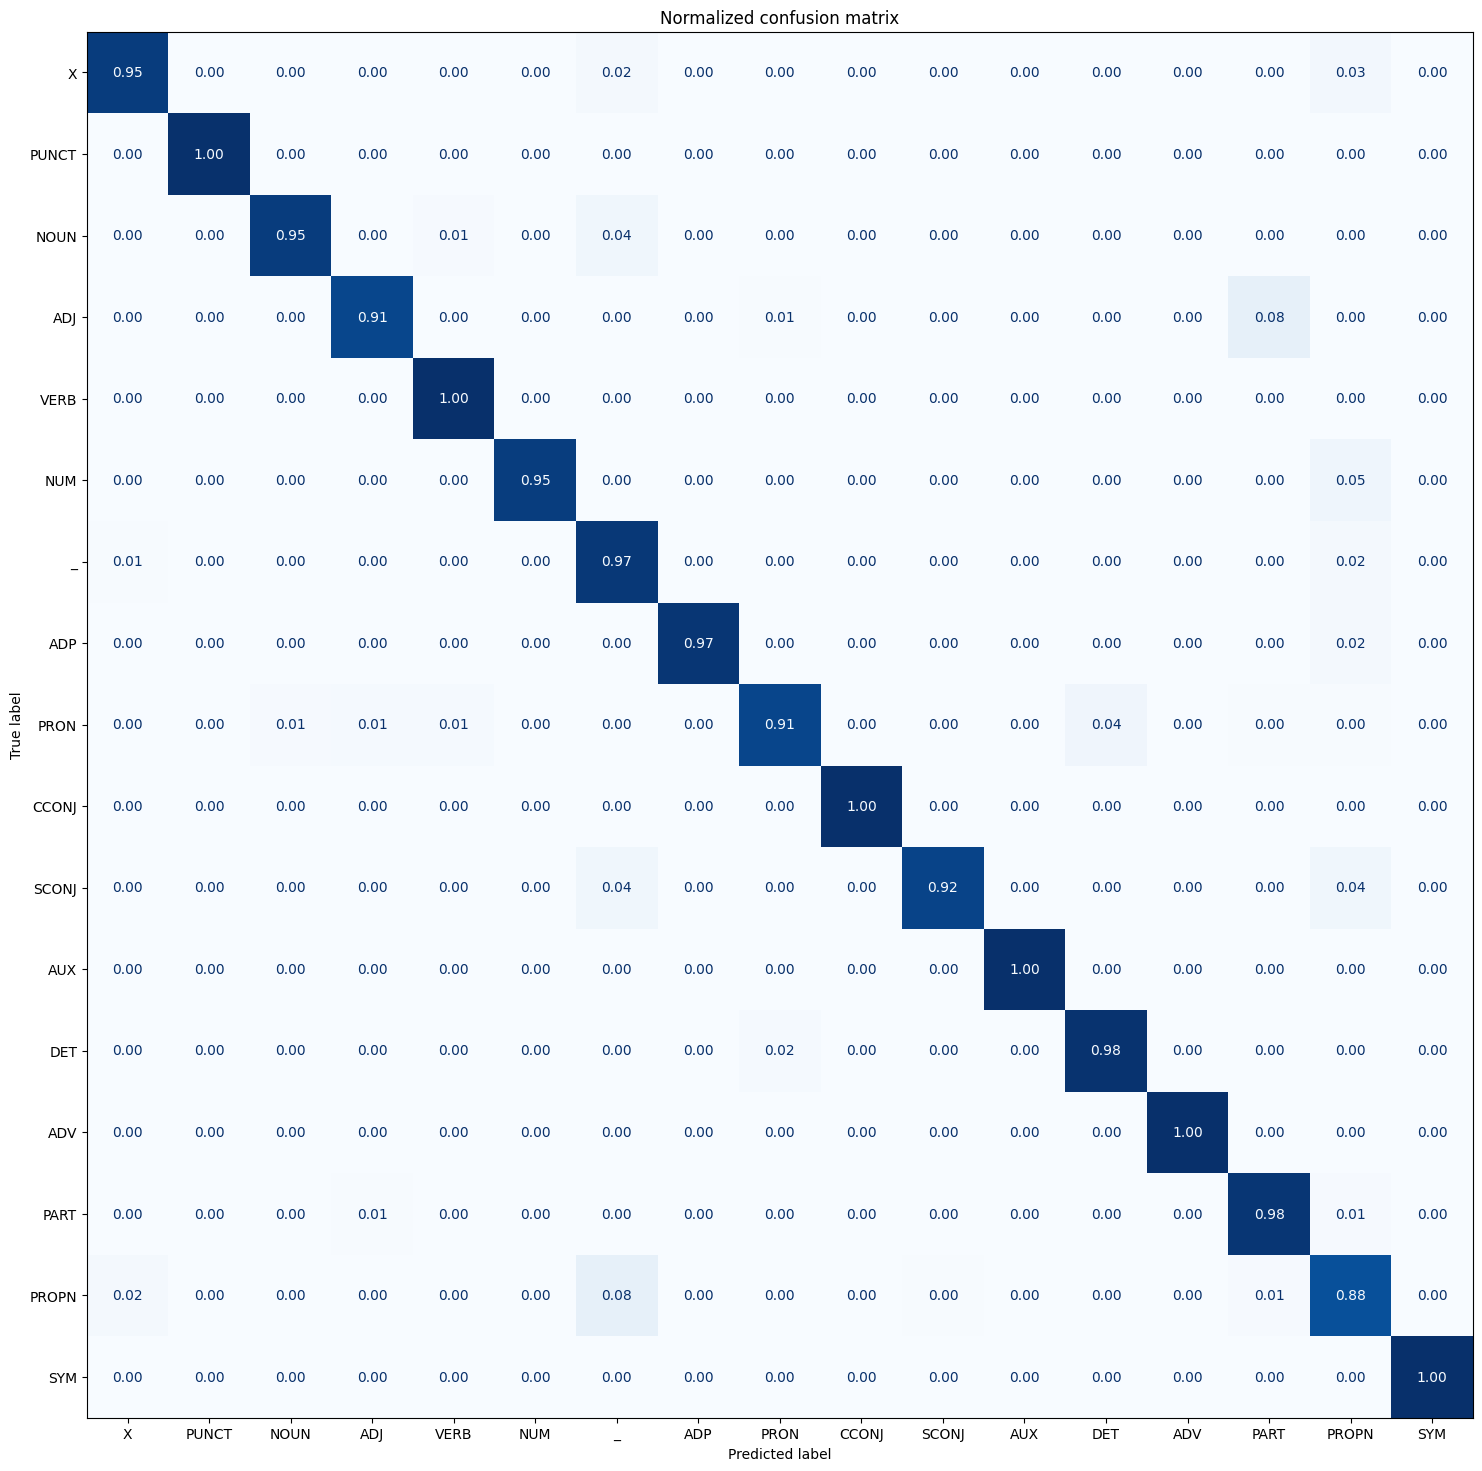

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    """
    Plot confusion 18x18 matrix.
    
    Parameters
    ----------
    - y_preds : np.ndarray
        A numpy array contains the predictions.
    - y_true : np.ndarray
        A numpy array contains the original label_ids.
    - labels : list
        A list of labels names.
    """
    
    cm = confusion_matrix(y_true, y_preds, normalize="true")

    _, ax = plt.subplots(figsize=(18, 18))

    ax.set(
         xticks=np.arange(len(labels)),
         yticks=np.arange(len(labels)),
         xticklabels=labels,
         yticklabels=labels
    )
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"], df_tokens["labels"].unique().tolist())

### 6.1.8 Get the **Top 3** Total Loss Examples
Now that we’ve examined the errors at the token level, let’s move on and look at
**sequences with high losses**. For this calculation, we’ll revisit our “unexploded” DataFrame and calculate the total loss by summing over the loss per token. To do this, let’s first write a function that helps us display the token sequences with the labels and the losses.

In [ ]:
def get_samples(df):
    """
    Get a new prediction dataframe for each sample in `df`.
    
    Parameters
    ----------
    - df : pd.DataFrame
    
    Returns
    -------
    - df_tmp : pd.DataFrame
        a new transposed dataframe of this particular columns
        ["tokens", "labels", "preds", "losses"].
    """
    
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, _ in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")

        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                                "preds": preds, "losses": losses}).T
        yield df_tmp

        
# Get the top 3 highest loss examples in our dataset 
df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
tokens,▁وأضاف,▁و,▁أ,ضاف,▁نحن,▁في,▁حالة,▁ان,ق,راض,...,▁البد,و,▁من,▁ال,وجود,▁على,▁الأرض,▁,.,</s>
labels,_,CCONJ,VERB,IGN,X,ADP,NOUN,NOUN,IGN,IGN,...,ADJ,IGN,ADP,NOUN,IGN,ADP,NOUN,PUNCT,IGN,IGN
preds,_,CCONJ,VERB,VERB,X,ADP,NOUN,NOUN,NOUN,NOUN,...,NOUN,NOUN,ADP,NOUN,NOUN,ADP,NOUN,PUNCT,PUNCT,NOUN
losses,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.06,0.00,0.00,...,6.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
tokens,▁لا,▁شك,▁في,▁ان,▁هناك,▁من,▁ي,رد,ّ,▁على,...,▁ما,▁نفع,له,▁نفع,ل,▁ه,▁اليوم,▁,.,</s>
labels,PART,NOUN,ADP,SCONJ,ADV,DET,VERB,IGN,IGN,ADP,...,DET,_,IGN,VERB,IGN,PRON,NOUN,PUNCT,IGN,IGN
preds,PART,NOUN,ADP,SCONJ,ADV,DET,VERB,VERB,VERB,ADP,...,DET,_,_,VERB,VERB,PRON,NOUN,PUNCT,PUNCT,ADJ
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
tokens,▁بالا,مس,▁ب,▁الأم,س,▁،,▁سمعت,▁احد,▁الخبر,اء,...,▁ولا,▁و,▁لا,▁يجد,ون,▁الدو,اء,▁,.,</s>
labels,_,IGN,ADP,NOUN,IGN,PUNCT,VERB,NOUN,NOUN,IGN,...,_,CCONJ,PART,VERB,IGN,NOUN,IGN,PUNCT,IGN,IGN
preds,_,_,ADP,NOUN,NOUN,PUNCT,VERB,NOUN,NOUN,NOUN,...,_,CCONJ,PART,VERB,VERB,NOUN,NOUN,PUNCT,PUNCT,ADJ
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.01,0.00,...,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00


It is apperant that there are some mistakes in the original annotation of the data; for example, the word `نحن` was originally labeled as `X` which is incorrect and it should be `PRON`, `.` was originally labeled as `IGN` and it should be `PUNCT`.

### 6.1.9 Conclusion
With this simple analysis, I've identified some weaknesses in both the model and the dataset. Typically, I should solve these problems by refining the dataset and retrain the model again, however, the process of refining the dataset is time-consuming and I think that 97% accuracy is a great result by the way.

## 6.2 Pushing the Model to the Hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub("Commit Successfully")

events.out.tfevents.1705268412.c6cbf44d16cb.26.0:   0%|          | 0.00/7.01k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.28k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/mohammedaly2222002/xlm-roberta-base-finetuned-ud-arabic/commit/bf9a7ff9ad345f199c3f4233814d45dd67adcdb0', commit_message='Commit Successfully', commit_description='', oid='bf9a7ff9ad345f199c3f4233814d45dd67adcdb0', pr_url=None, pr_revision=None, pr_num=None)

## 6.3 Loading the Model as a `Hugging Face Pipeline`

In [1]:
from transformers import pipeline

pos_tagger = pipeline("token-classification", "mohammedaly2222002/xlm-roberta-base-finetuned-ud-arabic")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [41]:
text = "اشترى خالد سيارة، و أصبح يمتلك 3 سيارات."

predictions = pos_tagger(text)
words = [item["word"] for item in predictions]
predicted_entities = [item["entity"] for item in predictions]


print(f"words:    {words}")
print(f"entites:  {predicted_entities}")

words:    ['▁اشتر', 'ى', '▁خالد', '▁سيارة', '،', '▁و', '▁أصبح', '▁يمتلك', '▁3', '▁سيارات', '.']
entites:  ['VERB', 'VERB', 'X', 'NOUN', 'PUNCT', 'CCONJ', 'VERB', 'VERB', 'NUM', 'NOUN', 'PUNCT']


## 6.4 Displaying Prediction as NetworkX Graph

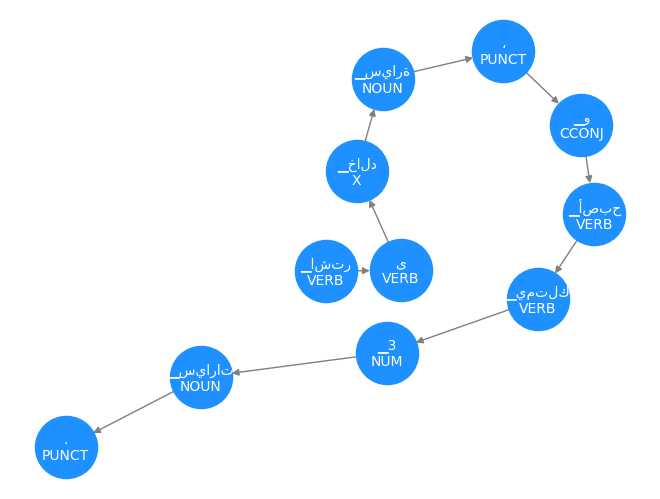

In [80]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i, word in enumerate(words):
    G.add_node(word, pos=predicted_entities[i])

# Add edges based on POS relationships
for i in range(len(words) - 1):
    G.add_edge(words[i], words[i+1])

# Plot the graph with labels
pos = nx.spring_layout(G)
node_labels = {node: f"{node}\n{G.nodes[node]['pos']}" for node in G.nodes}

nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=2000, node_color='dodgerblue', font_size=10, font_color='white', edge_color='gray')
plt.show()

## 6.5 Test Model on Different Test Cases

In [ ]:
test_cases = [
    "ذهب الطبيب إِلى المستشفى.",
    "رجع محمد من المدرسة.",
    "يُصَلِّي أبي فِي المَسجِدِ!",
    "أتكلم اللغة الفرنسية",
    "اشترى خالد السيارة، و أصبح عنده 3 سيارات.",
    "عادت البنت الى المنزل بعد ما انهت يومها الدراسي."
]

test_cases_df = pd.DataFrame(test_cases, columns=["text"])
test_cases_df

,text
0,ذهب الطبيب إِلى المستشفى.
1,رجع محمد من المدرسة.
2,يُصَلِّي أبي فِي المَسجِدِ!
3,أتكلم اللغة الفرنسية
4,اشترى خالد السيارة، و أصبح عنده 3 سيارات.
5,عادت البنت الى المنزل بعد ما انهت يومها الدراسي.


In [ ]:
def get_predicitons(df):
    """
    Get predictions for each example in the `df` using 
    the `Pipeline`.
    
    Parameters
    ----------
    - df : pd.DataFrame
        A pandas dataframe contains text to be predicted.
    
    Returns
    -------
    - Generator : pd.DataFrame
        Output of the pos_tagger as a pandas dataframe.
    """
    
    for row in df.iterrows():
        text = row[1]["text"]
        df = pd.DataFrame(pos_tagger(text))
        yield df

In [ ]:
for prediction_df in get_predicitons(test_cases_df):
    display(prediction_df[["word", "entity", "score"]])

,word,entity,score
0,▁,VERB,0.999519
1,ذهب,VERB,0.999655
2,▁الطبيب,NOUN,0.979260
3,▁إ,ADP,0.999777
4,ِ,ADP,0.979798
5,لى,ADP,0.999731
6,▁المستشفى,NOUN,0.989932
7,.,PUNCT,0.999757


,word,entity,score
0,▁,VERB,0.998998
1,رجع,VERB,0.999067
2,▁محمد,X,0.698222
3,▁من,ADP,0.999924
4,▁المدرسة,NOUN,0.999301
5,.,PUNCT,0.999779


,word,entity,score
0,▁ي,VERB,0.992819
1,ُ,VERB,0.980516
2,ص,VERB,0.950051
3,َ,VERB,0.864152
4,ل,VERB,0.838597
5,ِّ,VERB,0.566848
6,ي,VERB,0.985834
7,▁أبي,X,0.815331
8,▁ف,ADP,0.999721
9,ِ,ADP,0.799258


,word,entity,score
0,▁أ,VERB,0.983782
1,تكلم,VERB,0.995720
2,▁اللغة,NOUN,0.999437
3,▁الفرنسية,ADJ,0.994732


,word,entity,score
0,▁اشتر,VERB,0.998971
1,ى,VERB,0.999420
2,▁خالد,X,0.820448
3,▁السيارة,NOUN,0.998101
4,،,PUNCT,0.999907
5,▁و,CCONJ,0.999952
6,▁أصبح,VERB,0.999749
7,▁عند,_,0.898724
8,ه,PRON,0.998846
9,▁3,NUM,0.999828


,word,entity,score
0,▁عادت,VERB,0.999737
1,▁البن,X,0.585063
2,ت,X,0.888762
3,▁الى,ADP,0.999949
4,▁المنزل,NOUN,0.999708
5,▁بعد,ADP,0.999910
6,▁ما,DET,0.999197
7,▁انه,VERB,0.999257
8,ت,VERB,0.999397
9,▁يوم,NOUN,0.992871
